This is massively based on `string_MSM_analysis_TICS_deep_time_dev` where I took the MSM from Sergio's code, and took a square within this space. Now we need to make this process iterable, so I am making a python session (for now Jupyter notebook, but will be Python after, so we can put it into a bash script since there is a bash component to this as well)



Selecting for certain energies might seem dumb but we still have the overall shape of the FES and some empty regions that we do not want to account for... so we leave the code as is


I will leave this as an Ipython notebook as well so I can see how I made this, with the notes but Python code is one primarily executed


#### obs: I use the dictionary created in making the square (under section: Loop through each square), which will take a variable from bash as to which grid to use (0-2916). You can therefore use this dictionary to refer later to which square belongs to what part of the FES

# TODO :
## make this iterative python script
## save image of FES and taken data points so we can refer to it later if we need
## bash script to process this
## don't write anything to a certain directory if there is nothing to write (ie empty FES space)

# imports ,etc

In [1]:
import os
import pickle
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt


logging.getLogger("stringmethod").setLevel(logging.ERROR)
sys.path.append("../../string-method-gmxapi/")
import string_tica_msm as my_msm

['/data2/GLUT5_string/string/analysis/scripts', '/home/semccomas/anaconda3/envs/string_method/lib/python38.zip', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/lib-dynload', '', '/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages', '../../string-method-gmxapi/', '../../string-method-gmxapi/stringmethod/simulations/../../']


In [14]:
MSM_sim_dir = "../../string_sims/TMD_initial_path/influx_BFRU_gate_CV"
F_extent_dir = '../../string_sims/TMD_initial_path/influx_BFRU_gate_CV'
#grid = sys.argv[1]
grid = 823

F = np.load(f'{F_extent_dir}/F_MSM.npy')
F_for_plotting = np.load(f"{MSM_sim_dir}/F_MSM.npy")
extent = np.load(f'{F_extent_dir}/extent_MSM.npy')
cv_proj = np.load(f'{MSM_sim_dir}/cv_proj_MSM.npy')  #IC, EC


cv_labels = ["Intracellular gate (nm)", "Extracellular gate (nm)"]

xlim = (0.9,1.6)
ylim = (0.8,1.6)

In [15]:
len(cv_proj)

202944

In [16]:
def get_square(data, IC_leftmost, IC_rightmost, EC_lowermost, EC_uppermost, IC_index, EC_index):
    '''
    IC index should be 0 or 1 depending on where it exists in data, same for EC
    '''
    
    col0m = np.logical_and(data[:,IC_index]>= IC_leftmost, data[:,IC_index]<=IC_rightmost) #IC column mask
    col1m = np.logical_and(data[:,EC_index]>= EC_lowermost, data[:,EC_index]<=EC_uppermost) #EC column mask

    col0_1 = data[col0m & col1m]
    
    IC_selected_region = col0_1[:,IC_index]
    EC_selected_region = col0_1[:,EC_index]
    
    return IC_selected_region, EC_selected_region

# Loop through each square region

In [17]:
IC_extent = np.linspace(extent[0], extent[1], 55)
EC_extent = np.linspace(extent[2], extent[3], 55)

## reading grid left to right, then down a row and left to right again. No reason for this. 

grid_label = 0
grid_label_coord_dict = {}

for y_grid_index in range(0, 55):
    for x_grid_index in range(0, 55):
        if x_grid_index < 54 and y_grid_index < 54:
            #print(x_grid_index, ':x_left', y_grid_index, ':y_bottom')
            #print(x_grid_index + 1, ':x_right', y_grid_index, ':y_bottom')
            #print(x_grid_index, ':x_left', y_grid_index + 1, ':y_top')
            #print(x_grid_index + 1, ':x_right', y_grid_index + 1, ':y_top')
            
            
            IC_leftmost = IC_extent[x_grid_index] - 0.01
            IC_rightmost = IC_extent[x_grid_index + 1] + 0.01
            EC_uppermost = EC_extent[y_grid_index + 1] + 0.01
            EC_lowermost = EC_extent[y_grid_index] - 0.01

            coords = [IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost]    
            grid_label_coord_dict[grid_label] = coords
            grid_label = grid_label + 1

            
IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost = grid_label_coord_dict[grid]            
print(IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost)

1.0816209074074075 1.1135025925925925 1.0542957777777777 1.0187406666666665


In [18]:
np.diff(IC_extent)[0] / 2 + 0.001

0.006940842592592588

#### We will mask `F` to return only the values in the range between `min_F` and `max_F`. This is `all_min_vals`.
- If you want to be sure that you are plotting the correct range, just plot as this in the FES plot:
```
ax.scatter(all_mins_vals[:,0], all_mins_vals[:,1])
```
 

---

#### Then, take a specific square of all these values on the 55x55 grid, which becomes `all_min_vals_selected_region`
- This is however, on a 55x55 grid (based on the MSM calculations bandwidth) so it will not match the `cv_proj` just yet

In [19]:
min_F = 0
max_F = 15


IC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[1]
EC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[0]



#Return the IC&EC gate values where F is within specified range
IC_min_vals = []
EC_min_vals = []
for val_IC, val_EC in zip(IC_extent[IC_min_indices], EC_extent[EC_min_indices]):
    IC_min_vals.append(val_IC)
    EC_min_vals.append(val_EC)

all_min_vals = np.vstack((IC_min_vals, EC_min_vals)).T


IC_selected_region, EC_selected_region = get_square(data = all_min_vals,
                                                    IC_leftmost=IC_leftmost,
                                                    IC_rightmost=IC_rightmost,
                                                    EC_lowermost=EC_lowermost,
                                                    EC_uppermost=EC_uppermost,
                                                    IC_index=0,
                                                    EC_index=1)

all_min_vals_selected_region = np.vstack((IC_selected_region, EC_selected_region)).T

In [20]:
all_min_vals

array([[1.28172787, 0.795414  ],
       [1.29360956, 0.795414  ],
       [1.30549124, 0.795414  ],
       ...,
       [1.04409417, 1.51094911],
       [0.98468574, 1.52650422],
       [0.99656743, 1.52650422]])

In [21]:
if np.shape(all_min_vals_selected_region)[0] == 0:
    print(f"Nothing in space for grid {grid} at {grid_label_coord_dict[grid]}")
    quit()

In [22]:
all_min_vals_selected_region

#IC_mean = np.mean([IC_selected_region[0], IC_selected_region[1]])
#EC_mean = np.mean([EC_selected_region[0], EC_selected_region[2]])
#print(np.round([IC_mean, EC_mean],3))

array([[1.09162091, 1.02874067],
       [1.10350259, 1.02874067],
       [1.09162091, 1.04429578],
       [1.10350259, 1.04429578]])

#### Use these minima in a designated square space (`all_min_vals_selected_region`) to find all values in `data` (`cv_proj` with removed first frame from the CV values) that are **close to** each point, specified by `margin`

The reason that we do this is that we don't want only those points on the minima but everything in that space. Here below is a picture example:
<img src="./images_for_jup/example_extract.png" style="height:300px"> 
Where:
* blue dots are `all_min_vals` between 3 - 4
* orange dots are `all_min_vals_selected_region`. Each of these is in `IC_region_bead` & `EC_region_bead` as shown below
* pink dots are then `all_nearby_minima_square`, as calulated below


You notice that the dots aren't perfect, but I think this is likely ok, it is still better than taking an entire square directly from `data` as this would include much more of the green (for this pic anyway)

In [23]:
margin = np.diff(IC_extent)[0]/2 + 0.001  #dist between each point + a bit extra

data = cv_proj[:,1,:] ## wondering if you need to only take the drift value of swarms, not starting...

all_nearby_minima_square = []
all_nearby_indices = []

for IC_region_bead, EC_region_bead in all_min_vals_selected_region:
    IC_nearby = np.logical_and(data[:,0]>(IC_region_bead-margin), data[:,0]<(IC_region_bead+margin))
    EC_nearby = np.logical_and(data[:,1]>(EC_region_bead-margin), data[:,1]<(EC_region_bead+margin))
    all_nearby_minima_square.append(data[IC_nearby & EC_nearby])
    all_nearby_indices.append(np.where(IC_nearby & EC_nearby)[0])
    
all_nearby_minima_square = np.array(all_nearby_minima_square)
all_nearby_minima_square = np.concatenate(all_nearby_minima_square)

all_nearby_indices = np.array(all_nearby_indices)
all_nearby_indices = np.concatenate(all_nearby_indices)

print(np.shape(all_nearby_minima_square))

(739, 2)


/tmp/ipykernel_1003/44955742.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_minima_square = np.array(all_nearby_minima_square)
/tmp/ipykernel_1003/44955742.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_nearby_indices = np.array(all_nearby_indices)


In [24]:
max(all_nearby_minima_square[:,1])

1.05121

#### Lastly, check that your points you have chosen match the FES before taking the `confout` files

Reiterate the process until you are happy

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
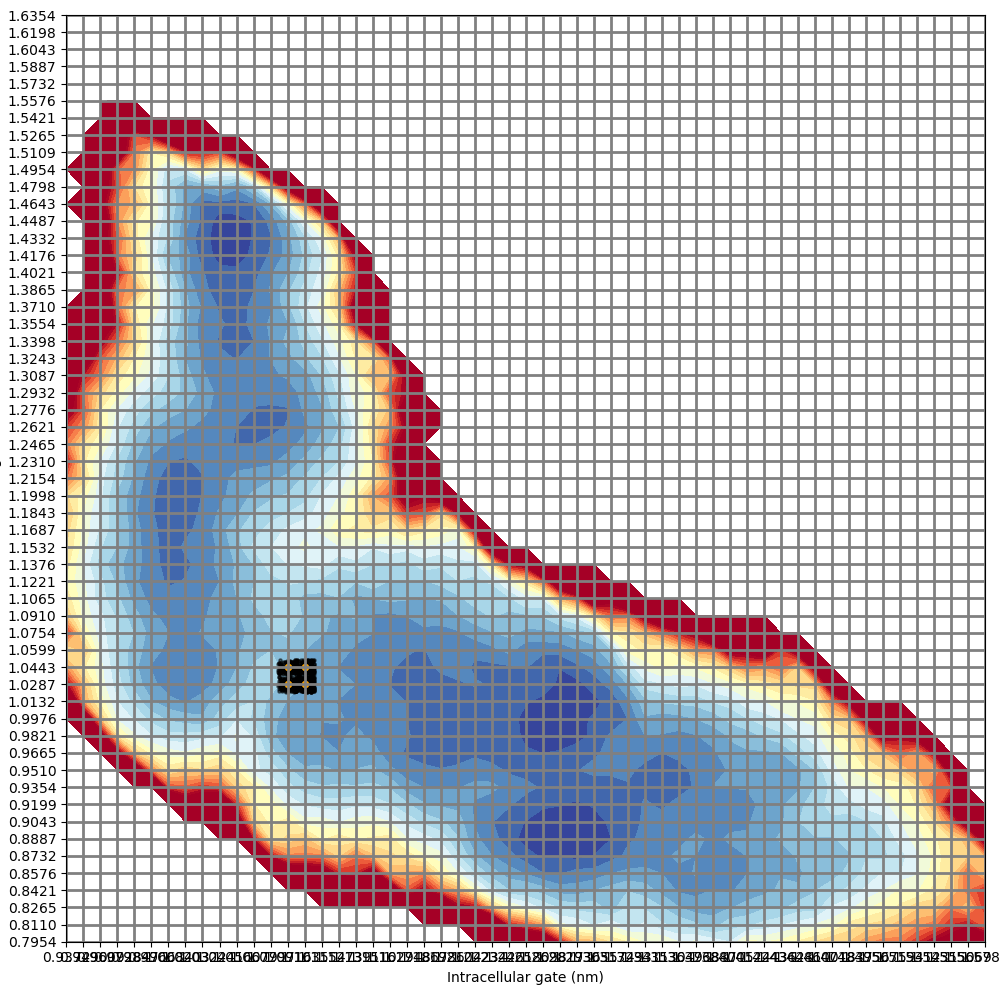

In [37]:
%matplotlib widget

f_max = 15


fig, ax = my_msm.plot_2D_heatmap(
    F_for_plotting,
    extent,
    f_max=f_max,
    cbar_label="Free Energy (kT)",
    xlabel=cv_labels[0],
    ylabel=cv_labels[1],
    xlim= None,
    ylim= None
)

fig.tight_layout()



xticks = np.linspace(extent[0], extent[1], 55)
yticks = np.linspace(extent[2], extent[3], 55)

ax.set_xticks(xticks)
ax.set_xticks(xticks, minor=True)
ax.set_yticks(yticks)
ax.set_yticks(yticks, minor=True)
ax.grid(which='both' , color = 'grey')

#ax.scatter(all_min_vals[:,0], all_min_vals[:,1], s = 10)
ax.scatter(all_nearby_minima_square[:,0], all_nearby_minima_square[:,1], s = 5, alpha = 0.5, c = 'black')
ax.scatter(all_min_vals_selected_region[:,0], all_min_vals_selected_region[:,1], c = 'orange',s = 20)
#ax.scatter(IC_mean,EC_mean, c = 'pink')


In [60]:
extent

array([0.937159, 1.57877 , 0.795414, 1.63539 ])

# Pt 2:
Get the confouts!!

#### Once satisfied with `all_nearby_minima_square`, get original iteration, bead, swarm 


Ok, so now we have the values and indices for `data` where we have the specified box and minima (`all_nearby_minima_square` and `all_nearby_indices`). We will use this function from the `inflecs_string_sims` script to get original iteration, bead, swarm from these indices so we can do analysis on the confout files

Same as in the inflecs script, I will make a `.sh` script to get the confouts of all the simulations found from the function, and put them together for analysis

---
We will also trim the dataset if it's quite big, and remove duplicates. We don't need to have > 3000 points I think... You can choose the size to make your dataset by `size_cutoff`

In [61]:
def get_it_bead_swarm_from_index(index_number, iteration_start):
    #### divide index by 448 to find which iteration it's in
    iteration = int(np.floor(index_number / (n_swarms * n_beads))) 
    

    #### find which index this dictated iteration starts on
    iteration_start_string_index = (n_swarms * n_beads) * iteration  


    #### take the difference of the iteration start index and the actual index
    #### The difference between the actual index and iteration index / 32 will be which bead 
    bead = int(np.floor((index_number - iteration_start_string_index) / n_swarms)) 


    #### find which index this bead starts on
    #### will be iteration start + (1-448)
    bead_start_string_index = iteration_start_string_index + (n_swarms * bead)


    #### Get actual index - bead index start, max diff should be 31
    swarm = index_number - bead_start_string_index
    
    actual_iteration = iteration + iteration_start
    #print(f"Returning iteration {actual_iteration}, bead {bead}, swarm {swarm}")
    
    
    if name_sim == 'influx_apo_gate_CV':
        indir = f'/mnt/cephfs/projects/2021071200_GLUT5_string_influx_TMD/GLUT5_string/string/string_sims/TMD_initial_path/{name_sim}/md'
    if name_sim == 'influx_BFRU_gate_CV':
        indir = f'/mnt/cephfs/projects/2021091701_GLUT5_string_influx_BFRU_TMD/GLUT5_string/string/string_sims/TMD_initial_path/{name_sim}/md'
        
    confout_statement = f"{indir}/{actual_iteration}/{bead + 1}/s{swarm}/traj_comp.xtc"
    print(f"Confout {index_number} should be in: {confout_statement}")
    return actual_iteration, bead, swarm, confout_statement

In [62]:
n_swarms = 32
n_beads = 14
name_sim = 'influx_BFRU_gate_CV'
confout_list = []

for index in all_nearby_indices:
    iteration, bead, swarm, confout = get_it_bead_swarm_from_index(index, 100)
    confout_list.append(confout)
    #print()

#take uniques and trim dataset    
confout_list = list(set(confout_list))
size_cutoff = 1000
random_start = int(np.random.randint(0, high=9, size = 1))

if len(confout_list) > size_cutoff:
    #slice_int = int(np.floor(len(confout_list) / float(size_cutoff)))
    #confout_list = confout_list[random_start::slice_int]
    confout_list = np.random.choice(confout_list, size_cutoff)

Confout 3546 should be in: /mnt/cephfs/projects/2021091701_GLUT5_string_influx_BFRU_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_BFRU_gate_CV/md/107/13/s26/traj_comp.xtc
Confout 2197 should be in: /mnt/cephfs/projects/2021091701_GLUT5_string_influx_BFRU_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_BFRU_gate_CV/md/104/13/s21/traj_comp.xtc
Confout 95373 should be in: /mnt/cephfs/projects/2021091701_GLUT5_string_influx_BFRU_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_BFRU_gate_CV/md/312/13/s13/traj_comp.xtc


In [63]:
print(all_nearby_indices[0],confout_list[0])
grid

3546 /mnt/cephfs/projects/2021091701_GLUT5_string_influx_BFRU_TMD/GLUT5_string/string/string_sims/TMD_initial_path/influx_BFRU_gate_CV/md/312/13/s13/traj_comp.xtc


32

In [64]:
confout_path=f'../confout_files/FES_grids_confouts/{name_sim}/{grid}'
if not os.path.isdir(confout_path):
    os.mkdir(confout_path)
logfile = open(f'{confout_path}/cluster_logs.txt', 'w')
trjcat_inflecs = open('./FES_grids_confouts_selection.sh', 'w')

trjcat_inflecs.write('#!/bin/bash')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -p tcb')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -J conf')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -t 03:00:00')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -N 1 --ntasks-per-node=4')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('#SBATCH -e error.err -o output.out')
trjcat_inflecs.write('\n')



trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'mkdir {confout_path}')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'echo "removing all old pdbs in {confout_path}"')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'rm {confout_path}/*pdb ')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('module unload gromacs')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('module load gromacs/2020.4')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')

for i, n in enumerate(confout_list):
    outname=n.split('/')
    outname='-'.join(outname[-4:-1])
    if 'traj_comp' in n:
        trjcat_inflecs.write(f'gmx editconf -f {n[:-13]}confout.gro -o {confout_path}/{outname}.clu{i}.pdb' + '\n')
    logfile.write(f'{outname}.clu{i}' + '\n')
    
    if i==0:
        trjcat_inflecs.write(f"cp {confout_path}/{outname}.clu{i}.pdb {confout_path}/FES_grid_all.start.pdb" + '\n')
    
### I know this looks messed up but this is how we can use string formatting and also use curly brackets in one        
trjcat_inflecs.write(f'eval "cat ./{confout_path}/*.clu{{0..')
trjcat_inflecs.write(str(i))
trjcat_inflecs.write(f'}}.pdb > ./{confout_path}/FES_grid_all.pdb"')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx trjconv -f {confout_path}/FES_grid_all.pdb -o {confout_path}/FES_grid_all.xtc')
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'rm {confout_path}/FES_grid_all.pdb')



trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx pairdist -f {confout_path}/FES_grid_all.xtc '
                     f'-s ../confout_files/tpr_files/{name_sim}.wholesys.tpr '
                    '-ref "com of resid 30 to 37" -sel "com of resid 289 to 295" '
                    f'-o {confout_path}/FES_grid_all.EC_gate.xvg -xvg none'
                    )
trjcat_inflecs.write('\n')
trjcat_inflecs.write('\n')
trjcat_inflecs.write(f'gmx pairdist -f {confout_path}/FES_grid_all.xtc '
                     f'-s ../confout_files/tpr_files/{name_sim}.wholesys.tpr '
                    '-ref "com of resid 136 to 145" -sel "com of resid 386 to 394" '
                    f'-o {confout_path}/FES_grid_all.IC_gate.xvg -xvg none'
                    )

trjcat_inflecs.close()        
logfile.close()